In [2]:
# load Boston dataset
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# normalize data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [3]:
# build network
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
# train model with k-fold validation (due to small dataset n=404)
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)

    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

In [7]:
# compute average mae (mean average error) for each epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                                        for i in range(num_epochs)]

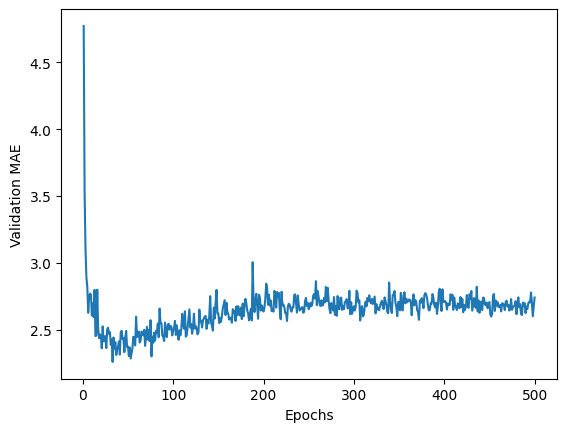

In [8]:
# plot validation score (mae) per epoch
import matplotlib.pyplot as plt\

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

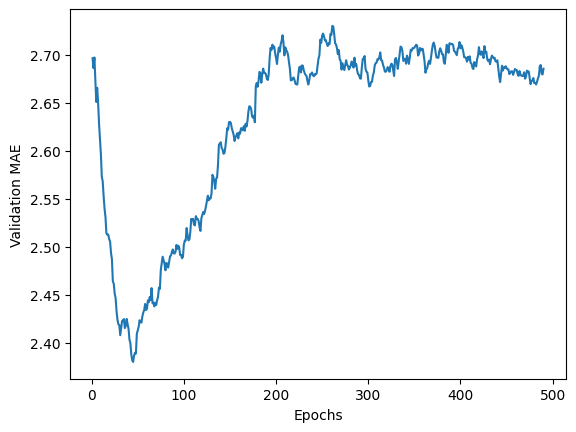

In [9]:
# exclude first 10 points and smooth plot for clarity
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append((previous * factor) + (point * (1 - factor)))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [15]:
# train final network with tuned hyperparameters (num_epochs=80)
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2023-03-01 12:22:30.952082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step - loss: 18.2534 - mae: 2.7116


2023-03-01 12:22:42.210436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
